In [40]:
import os

import cv2
from IPython.display import display
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import torch

from segment_anything import SamAutomaticMaskGenerator, sam_model_registry


In [3]:
checkpoints = "checkpoints"
vit_h = "sam_vit_h_4b8939.pth"
vit_b = "sam_vit_b_01ec64.pth"
vit_l = "sam_vit_l_0b3195.pth"

In [32]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [33]:
sam = sam_model_registry["vit_h"](checkpoint=os.path.join(checkpoints, vit_h))
sam.to(device=device)

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-31): 32 x Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

In [41]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    polygons = []
    color = []
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
        ax.imshow(np.dstack((img, m*0.35)))

In [34]:
mask_generator = SamAutomaticMaskGenerator(sam)

In [197]:
image_path = os.path.join("demo", "src", "assets", "data", "rail.png")

In [198]:
image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
masks = mask_generator.generate(image)

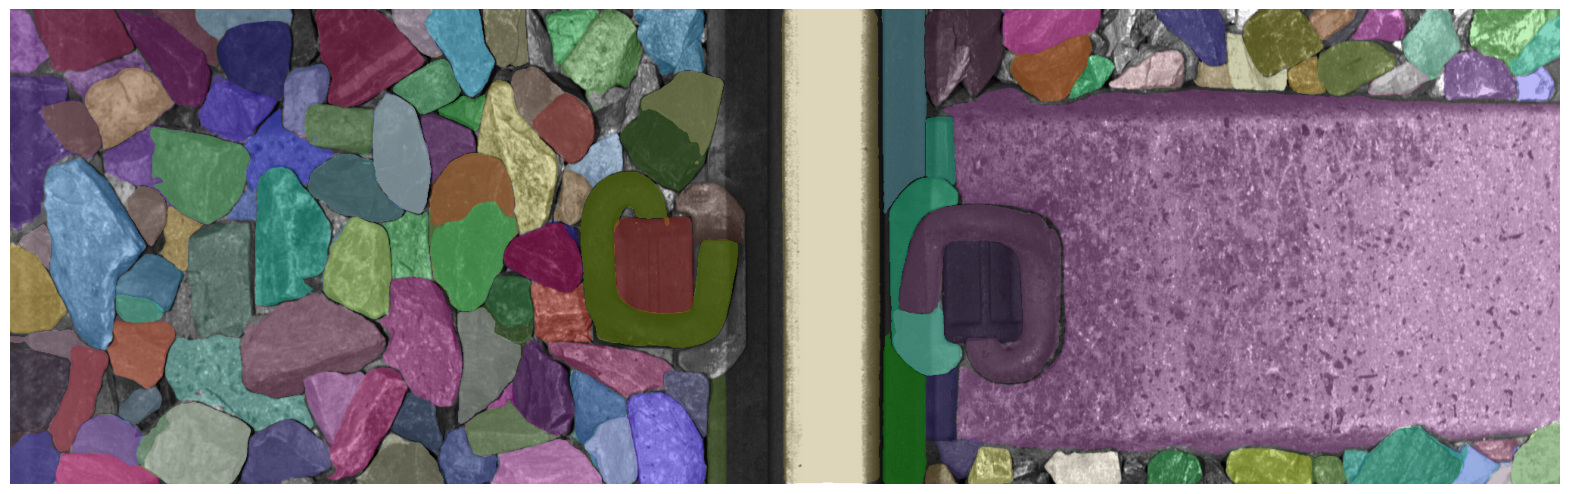

In [199]:
plt.figure(figsize=(20, 20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()

In [208]:
## remmove those masks with area less than 10% of the largest mask
def filter_masks(masks):
    if len(masks) == 0:
        return masks
    sorted_masks = sorted(masks, key=(lambda x: x['area']), reverse=True)
    largest_mask = sorted_masks[0]
    filtered_masks = [largest_mask]
    for mask in sorted_masks[1:]:
        if mask['area'] > largest_mask['area'] * 0.01:
            filtered_masks.append(mask)
    return filtered_masks

In [209]:
filter_masks = filter_masks(masks)
len(filter_masks)

118

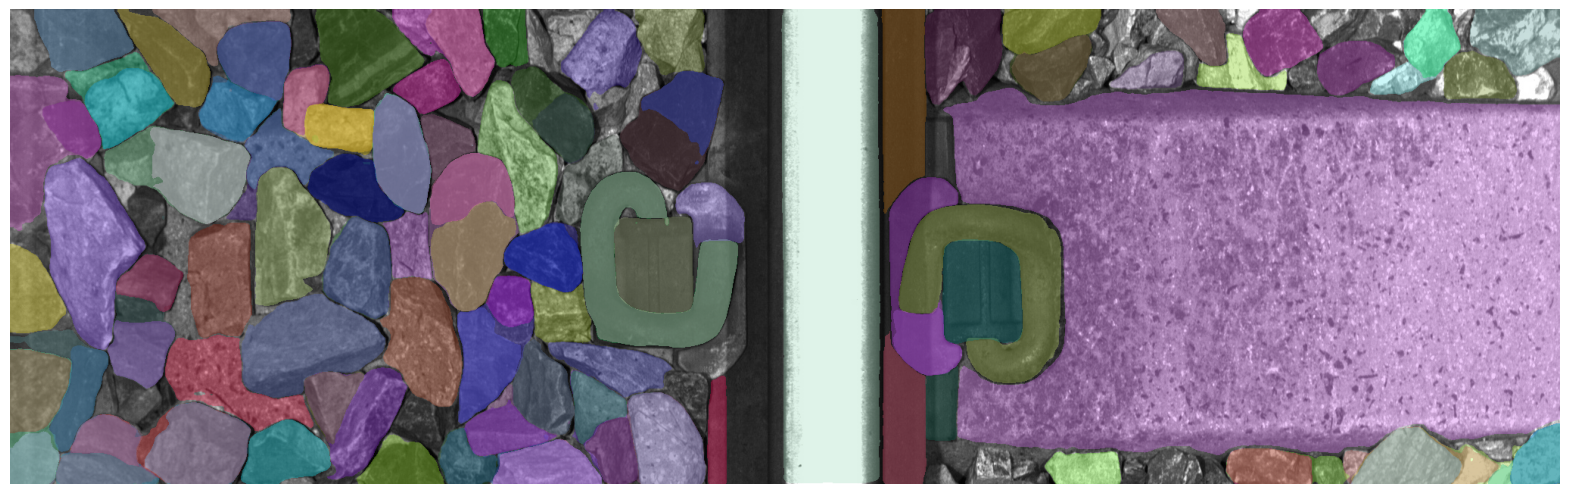

In [210]:
plt.figure(figsize=(20, 20))
plt.imshow(image)
show_anns(filter_masks)
plt.axis('off')
plt.show()

In [100]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    polygons = []
    color = []
    
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
            polygons.append(img)
            color.append(color_mask)
        ax.imshow(np.dstack((img, m*0.35)))

In [104]:
masks[1].keys()

dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])